# JPX - Detailed EDA
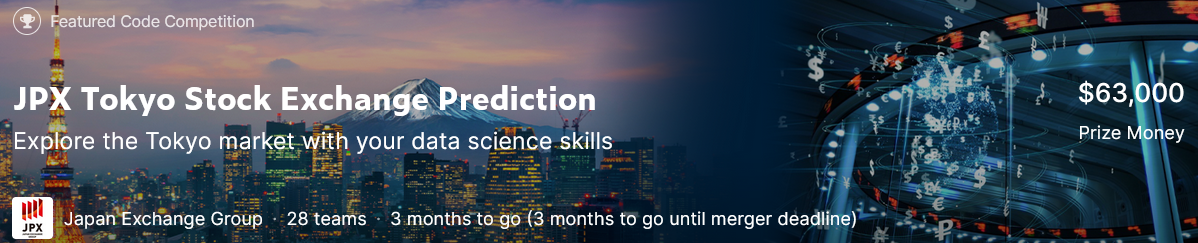

## About this Competition
In this competition, historic data for a variety of Japanese stocks and options are given. The competitors are challenged to rank the change ratio of adjusted close price between the next day and 2 days later for each stock. Also, note that the **forecasting phase leaderboard** will be determined using **real market data** gathered after the submission period closes.

## About this Notebook
In this kernel, I will do exploratory data analysis mainly using files in directory `train_files/` to facilitate the preliminary understanding of the data; also, a simple baseline model will be implemented to illustrate the usage of time series API.

<a id="toc"></a>
## Table of Contents
* [1. `stock_prices.csv`](#stock_prices)
    * *[File Description](#file_desc)*
    * *[Simple Summary](#simple_sum)*
    * *[Primary Key](#pk)*
    * *[Missing Values](#missing)* 
    * *[Target Exploration](#target)* 
    * *[Stock List Fusion](#stock_list)*
    * *[Secondary Stocks](#stock_prices_sec)*
* [2. `trades.csv`](#trades)
    * *[File Description](#file_desc_trades)*
    * *[Simple Summary](#simple_sum_trades)*
    * *[Section](#section)*
* [3. `options.csv`](#options)
    * *[File Description](#file_desc_opts)*
    * *[Simple Summary](#simple_sum_opts)*
    * *[Primary Key](#pk_opts)*
    * *[Zero Values](#zero_values)*
    * *[Option Code](#option_code)*

## Import Packages

In [ ]:
import os
import gc
import warnings

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration
warnings.simplefilter('ignore')
pd.set_option('max_column', None)
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')

In [ ]:
TRAIN_DIR = "../input/jpx-tokyo-stock-exchange-prediction/train_files"

## Load Data
Let's load data first. It doesn't take too much time!

In [ ]:
%%time

df_prices = pd.read_csv(os.path.join(TRAIN_DIR, 'stock_prices.csv'))
df_prices_sec = pd.read_csv(os.path.join(TRAIN_DIR, 'secondary_stock_prices.csv'))
df_fins = pd.read_csv(os.path.join(TRAIN_DIR, 'financials.csv'))
df_opts = pd.read_csv(os.path.join(TRAIN_DIR, 'options.csv'))
df_trades = pd.read_csv(os.path.join(TRAIN_DIR, 'trades.csv'))
stock_list = pd.read_csv(os.path.join("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv"))

<a id="stock_prices"></a>
## 1. `stock_prices.csv`
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)


<a id="file_desc"></a>
### *File Description*
The core file of interest, including the daily closing price for each stock and the target column. Following is column information recorded in `stock_price_spec.csv`:
* `RowId`: Unique ID of price records, the combination of `Date` and `SecuritiesCode`.
* `Date`: Trade date.
* `SecuritiesCode`: Local securities code.
* `Open`: First traded price on a day.
* `High`: Highest traded price on a day.
* `Low`: Lowest traded price on a day.
* `Close`: Last traded price on a day.
* `Volume`: Number of traded stocks on a day.
* `AdjustmentFactor`: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).
* `ExpectedDividend`: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
* `SupervisionFlag`: Flag of securities under supervision and securities to be delisted, for more information, please see [here](https://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html).
* `Target`: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

<a id="simple_sum"></a>
### *Simple Summary*
`ExpectedDividend` has severe missing, which is related to the **frequency of dividends paid**. Also, there are some missing prices to notice.

In [ ]:
def summarize(df, file_name, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {file_name}=====")
    print(f"Shape: {df.shape}")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   
    
    display(df.head(n_rows_to_show))

In [ ]:
summarize(df_prices, "stock_prices.csv")

<a id="pk"></a>
### *Primary Key*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

`RowID` is composed of `Date` and `SecuritiesCode`.

In [ ]:
row_id = (df_prices['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
          + df_prices['SecuritiesCode'].astype(str))
assert (df_prices['RowId'] == row_id).all()

In [ ]:
n_dates = df_prices['Date'].nunique()
date_min, date_max = df_prices['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices['SecuritiesCode'].nunique()

print(f"Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n"
      f"Number of unique stocks: {n_stocks}")

Over 90% of stocks have records for complete training period from `2017-01-04` to `2021-12-03`. However, we still need to pay attention to **missing values** in certain columns (*e.g.*, `ExpectedDividend`, price columns).

In [ ]:
n_dates_per_stock = df_prices.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates per Stock\nMin {n_dates_per_stock.min()} | "
             f"Max {n_dates_per_stock.max()}")
ax.set_xlabel("#Dates")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Approximately 20% of trading dates have all 2000 stocks' records. Again, the **missing values** should be noted.

In [ ]:
n_stocks_per_date = df_prices.groupby(['Date'])['SecuritiesCode'].count()
date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()
date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted',
           linewidth=2, label='Mean')
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--',
           linewidth=2, label='Median')
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{date_ratio_max}% of #Dates')
ax.set_title(f"Number of Stocks per Date\nMin {n_stocks_per_date.min()} | "
             f"Max {n_stocks_per_date.max()}")
ax.set_xlabel("#Stocks")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

<a id="missing"></a>
### *Missing Values*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Let's focus on records with **missing prices**.

In [ ]:
df_no_prices = df_prices[df_prices['Close'].isna()]
print(f"Number of samples without prices: {len(df_no_prices)}")

Number of stocks without prices has a maximum on `2020-10-01`. After doing some research, I find that it's because of [The Failure of Equity Trading System on October 1, 2020](https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html).

In [ ]:
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()
all_dates = sorted(df_prices['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 1900, 'y1': 2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Number of Stocks without Prices per Date",
    xaxis_title="Date",
    yaxis_title="Stock Count",
)
fig.show()

In [ ]:
assert (len(df_prices[df_prices['Date'] == '2020-10-01']) 
        == no_prices_per_date.max())

Over 90% of stocks have **only one date with missing prices**. And, the culprit is mainly the one I mentioned above, `2020-10-01`. 

In [ ]:
no_prices_per_stock = df_no_prices['SecuritiesCode'].value_counts()
stock_cnt_max = (no_prices_per_stock == no_prices_per_stock.min()).sum()
stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates w/o Prices per Stock\n"
             f"Min {no_prices_per_stock.min()} | "
             f"Max {no_prices_per_stock.max()}")
ax.set_xlabel("#Dates without Prices")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

<a id="target"></a>
### *Target Exploration*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Let's observe the behavior of target along with OHLCV plot!

In [ ]:
def plot_candle_with_target(stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [ ]:
for stock_code in df_prices['SecuritiesCode'].unique()[:3]:
    plot_candle_with_target(stock_code)

Target mean is a **right-skewed** distribution. Also, it has a large kurtosis, exhibiting tail data exceeding the tails of the normal distribution. For investors, high kurtosis of the return distribution implies the investor will experience occasional extreme returns (either positive or negative). This phenomenon is known as **kurtosis risk**. Hence, competitors should be aware of **outliers**. For more information, please refer to [Kurtosis](https://www.investopedia.com/terms/k/kurtosis.asp).

In [ ]:
target_mean_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Target standard deviation is again a **right-skewed** distribution, where some of the stocks have higher std (up to 0.06).

In [ ]:
target_std_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

The joint plot of number of dates (*i.e.*, records) per stock and target mean distribution shows that target mean increases proportionally to the number of dates. Moreover, the dispersion of target mean seems to be larger when the number of dates is smaller.  

In [ ]:
ax = sns.jointplot(x=n_dates_per_stock, y=target_mean_per_stock, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

With smaller number of dates per stock, the target value indeed shows **greater dispersion** (*i.e.*, greater standard deviation).

In [ ]:
ax = sns.jointplot(x=n_dates_per_stock, y=target_std_per_stock, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

Through [analysis](#n_dates_per_stock), we know that over 90% of stocks have records for complete training period (namely 1202 records). Hence, the further analysis removing this majority is done below. And, the conlusion is in line with the observations above, showing that smaller number of dates per stock corresponds to **greater dispersion**.

In [ ]:
n_dates_per_stock_ = n_dates_per_stock[n_dates_per_stock != 1202]
target_mean_per_stock_ = target_mean_per_stock[target_mean_per_stock.index.isin(n_dates_per_stock_.index)]

ax = sns.jointplot(x=n_dates_per_stock_, y=target_mean_per_stock_, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock (#Dates != 1202)')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

In [ ]:
target_std_per_stock_ = target_std_per_stock[target_std_per_stock.index.isin(n_dates_per_stock_.index)]

ax = sns.jointplot(x=n_dates_per_stock_, y=target_std_per_stock_, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock (#Dates != 1202)')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

Stock 4169 is *Enechange Ltd*, which is a Japan-based energy switching tool developer. We can see that the data starts on December 23, 2020. The IPO news can be found [here](https://thebridge.jp/en/2020/11/enechange-files-for-ipo). For more information, please refer to [Enechange](https://enechange.co.jp/en/).<br>Another thing to mention is that the stock with max target std is also 4169; hence, the analysis isn't repeated.

In [ ]:
tm_max = target_mean_per_stock.max()
stock_tm_max = target_mean_per_stock[target_mean_per_stock == tm_max].index.values[0]

print(f"Stock with max target mean is {stock_tm_max}.")
plot_candle_with_target(stock_tm_max)

Now, let's analyze target values from the perspective of **date**. This time, target mean distribution is **approximately symmetric**. However, it again has a large kurtosis. Hence, **outliers** should be carefully handled.

In [ ]:
target_mean_per_date = df_prices.groupby(['Date'])['Target'].mean()
target_mean_mean = target_mean_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_date.min(), 4)} | "
             f"Max {round(target_mean_per_date.max(), 4)} | "
             f"Skewness {round(target_mean_per_date.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_date.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

Target standard deviation is a **right-skewed** distribution, where some of the stocks have higher std (up to 0.06). An interesting thing is that the smallest std is **zero**. Let's see the reason behind the scene.

In [ ]:
target_std_per_date = df_prices.groupby(['Date'])['Target'].std()
target_std_mean = target_std_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_date.min(), 4)} | "
             f"Max {round(target_std_per_date.max(), 4)} | "
             f"Skewness {round(target_std_per_date.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_date.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

Now, we understand why target std becomes zero on September 29, 2020. The reason is the **failure of trading system** on October 1, 2020 as I mention above. Because the prices are missing on T+2 date. It's impossible to derive the target values for September 29, 2020.

In [ ]:
zero_target_std = target_std_per_date[target_std_per_date == 0].index.values
print(f"The trading dates with zero target std is {zero_target_std}.")

dates_after = df_prices[(df_prices['Date'] >= zero_target_std[0]) & 
                        (df_prices['Date'] < '2020-10-02')]['Date'].unique()
print(f"T+1 trading date of that date is {dates_after[1]}")
print(f"T+2 trading date of that date is {dates_after[2]}")

The joint plot of number of stocks per date and target mean distribution shows no significant patterns. But, the dispersion slightly increases when number of stocks per date grows.

In [ ]:
ax = sns.jointplot(x=n_stocks_per_date, y=target_mean_per_date, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Stocks per Date')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

A slight increase of dispersion is observed when number of stocks per date becomes larger.

In [ ]:
ax = sns.jointplot(x=n_stocks_per_date, y=target_std_per_date, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Stocks per Date')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

The trading date with the max target mean is `2018-12-25`. Hence, we can go to see what happened in `2018-12-27`, the T+2 trading date. After doing some searching, I find that the reason might be the **Wall Street’s biggest point gain in history**. For readers of interest, please refer to following news:<br>
* [Japanese stocks rally after Wall Street’s big rebound, but South Korea and Shanghai markets drop](https://www.latimes.com/business/la-fi-global-stocks-20181227-story.html)
* [U.S. markets close in positive territory after challenging day](https://www.washingtonpost.com/business/2018/12/27/us-markets-stumble-after-wednesdays-big-rebound/)

In [ ]:
tm_max = target_mean_per_date.max()
date_tm_max = target_mean_per_date[target_mean_per_date == tm_max].index.values[0]
print(f"Date with max target mean is {date_tm_max}.")

The trading date with the max target std is `2020-03-17`. Hence, we can go to see what happened in `2020-03-19`, the T+2 trading date. The first thought come to my mind is the prevalence of **COVID-19**. From the following news, we can see what happened at that time:
* [Asian shares tumble: S.Korea's Kospi drops 9%, Hong Kong 4%](https://mainichi.jp/english/articles/20200319/p2g/00m/0bu/076000c)
> Investors shift to cash as fears of a prolonged coronavirus-induced recession.

In [ ]:
ts_max = target_std_per_date.max()
date_ts_max = target_std_per_date[target_std_per_date == ts_max].index.values[0]
print(f"Date with max target std is {date_ts_max}.")

<a id='stock_list'></a>
### *Stock List Fusion*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Because stock list contains the metadata of stocks, I decide to fuse this information into the analysis of `stock_prices.csv`.

#### *File Description*
Mapping between the `SecuritiesCode` and company names, plus general information about which industry the company is in. Following is column information recorded in `stock_list_spec.csv`:
* `SecuritiesCode`: Local securities code.
* `EffectiveDate`: The effective date. (Need clarification.)
* `Name`: Name of security.
* `Section/Products`: Section/Product.
* `NewMarketSegment`: New market segment effective from 2022-04-04 (as of 15:30 JST on Mar 11 2022). For more information, please see [Overview of Market Restructuring](https://www.jpx.co.jp/english/equities/market-restructure/market-segments/index.html).
* `33SectorCode`: 33 sector code. 
* `33SectorName`: 33 sector name.
* `17SectorCode`: 17 sector code.
* `17SectorName`: 17 sector name.
>　For more information about sector code and name, please see [TOPIX Sector Indices / TOPIX-17 Series](https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_13_sector.pdf)
* `NewIndexSeriesSizeCode`: TOPIX New Index Series code.
* `NewIndexSeriesSize`: TOPIX New Index Series name.
> For more information about TOPIX New Index Series code and name, please see [TOPIX New Index Series / Size-based TOPIX](https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_12_size.pdf).
* `TradeDate`: Trade date to calculate `MarketCapitalization`.
* `Close`: Close price to calculate `MarketCapitalization`.
* `IssuedShares`: Issued shares.
* `MarketCapitalization`: Market capitalization on December 3, 2021.
* `Universe0`: A flag of prediction target universe (top 2000 stocks by market capitalization).

In [ ]:
summarize(stock_list, "stock_list.csv", n_rows_to_show=2)

`Universe0` correctly indicates the 2000 target stocks to predict.

In [ ]:
assert stock_list['Universe0'].sum() == 2000

**First Section (Domestic)** dominates `Secion/Products` of all stocks.

In [ ]:
sec_prod_val_cnt = stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of Section/Products")
plt.show()

Let's focus on 2000 target stocks. We can find that **First Section (Domestic)** still dominates `Secion/Products` of these stocks. And, the 2000 target stocks can be divided into only 5 categories.

In [ ]:
target_stock_list = stock_list[stock_list['Universe0']]
sec_prod_val_cnt = target_stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of Section/Products (2000 Target Stocks)")
plt.show()

Stocks in sectors **Information & Communication** and **Services** are the majority of the 33 industrial sectors defined by *Securities Identification Code Committee (SICC)*.

In [ ]:
sec_33_val_cnt = target_stock_list['33SectorName'].value_counts()
pct = sec_33_val_cnt / sec_33_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_33_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_33_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of 33 Sector Name (2000 Target Stocks)")
plt.show()

Stocks in series **IT & SERVICES, OTHERS** are the majority of the TOPIX-17 series defined by *Securities Identification Code Committee (SICC)*. And this category is comprised of stocks in sectors **Information & Communication**, **Services**, and **Other Products**, which can be verified by comparing sector ratios with series ratio.

In [ ]:
sec_17_val_cnt = target_stock_list['17SectorName'].value_counts()
pct = sec_17_val_cnt / sec_17_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_17_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_17_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of TOPIX-17 Series Name (2000 Target Stocks)")
plt.show()

Let's merge sector information with the stock price DataFrame to do some **sector-based** analysis.

In [ ]:
sec_info = target_stock_list[['SecuritiesCode', '33SectorName', '17SectorName']]
df_prices = pd.merge(df_prices, sec_info, on='SecuritiesCode')
df_prices.head()

With a broader view, we can observe that **Marine Transportation** has the highest target mean over the training period, followed by **Information & Communication** and **Services**. And, the only sector having negative target mean is **Banks**.

In [ ]:
target_mean_33sec = df_prices.groupby(['33SectorName'])['Target'].mean()
target_mean_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_33sec.index, y=target_mean_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Target Mean of Each Sector over Training Period")
ax.set_xlabel("33 Sector Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Mean")
plt.show()

As for target dispersion, **Information & Communication** has the highest target std over the training period, followed by **Services** and **Pharmaceutical**. And, **Fishery, Agriculture and Forestry** has the lowest.

In [ ]:
target_std_33sec = df_prices.groupby(['33SectorName'])['Target'].std()
target_std_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_std_33sec.index, y=target_std_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Target Std of Each Sector over Training Period")
ax.set_xlabel("33 Sector Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Std")
plt.show()

Let's step into the sector with the highest target mean, **Marine Transportation**. Stocks with top3 target mean are *Nippon Yusen K.K. (9101)*, *Kawasaki Kisen Kaisha, Ltd. (9107)*, and *Mitsui OSK Lines, Ltd. (9104)*.  Following are official websites of these companies:
* [NYK Line](https://www.nyk.com/english/)
* [TOP | KAWASAKI KISEN KAISHA, LTD.](https://www.kline.co.jp/en/index.html)
* [Mitsui O.S.K. Lines](https://www.mol.co.jp/en/)

In [ ]:
target_sector = 'Marine Transportation'
df_prices_marine = df_prices[df_prices['33SectorName'] == target_sector]
target_mean_marine = df_prices_marine.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_marine.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_marine.index, y=target_mean_marine.values, 
            order=target_mean_marine.index, palette=colors, ax=ax)
ax.set_title("Target Mean of Stocks in Sector Marine Transportation over Training Period")
ax.set_xlabel("Security Code")
ax.set_ylabel("Target Mean")
plt.show()

Interpreting target series on **daily** scale, we can find that stocks within the same sector have a strong **spatial dependency**. That is, the target series move in sync.

<div class="alert alert-info">
    <h5>Please zoom in the plot to check.</h5>
</div>

In [ ]:
unique_dates = sorted(df_prices['Date'].unique())

fig = go.Figure()
for stock_code in [9101, 9107, 9104]:
    df_ = df_prices_marine[df_prices_marine['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 3 Best Stocks in Marine Transportation",
)
fig.show()

Let's see how target series of stocks in the worst sector, **Bank**, behave over the training period. As we can see, the behavior is significantly different from that of the best sector, **Marine Transportation**. Only five of the stocks have positive target means. And, *Suruga Bank Ltd. (8358)* has the worst performance on average. Following is the of the official website of this company:
* [SURUGA bank Ltd.](https://www.surugabank.co.jp/surugabank/common/english/)

In [ ]:
target_sector = 'Banks'
df_prices_banks = df_prices[df_prices['33SectorName'] == target_sector]
target_mean_banks = df_prices_banks.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_banks.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_banks.index, y=target_mean_banks.values, 
            order=target_mean_banks.index, palette=colors, ax=ax)
ax.set_title("Target Mean of Stocks in Sector Banks over Training Period")
ax.set_xlabel("Security Code")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Mean")
plt.show()

Again, let's observe target series on **daily** scale. Stocks within the same sector have some **interrelationship** with each other. That is, the target series move in sync. 

<div class="alert alert-info">
    <h5>Please zoom in the plot to check.</h5>
</div>

In [ ]:
fig = go.Figure()
for stock_code in [8360, 8714, 8358]:
    df_ = df_prices_banks[df_prices_banks['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 3 Worst Stocks in Banks",
)
fig.show()

Finally, let's verify if stocks from different sectors have the relationship observed above. I select stocks *9101*, *9104*, *8714* and *8358* to illustrate the statement. Apparently, target series from different sectors have **weaker spatial dependency** compared with those from the same sector. 

<div class="alert alert-info">
    <h5>Please toggle the target series at the right panel to observe the results.</h5>
</div>

In [ ]:
fig = go.Figure()
for stock_code in [9101, 9104, 8714, 8358]:
    df_ = df_prices[df_prices['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 2 Best Stocks in Marine Transportation and 2 Worst in Banks",
)
fig.show()

<a id="stock_prices_sec"></a>
### *Secondary Stocks*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

#### *File Description*
This file contains data for **securities with relatively low liquidity**, meaning there are few opportunities to trade. Column information is the same as [`stock_prices.csv`](#stock_prices).
<div class="alert alert-danger">
    <h5>Stocks in this file won't be scored; however, they still contain valuable information for us to mine.</h5>
</div>

#### *Simple Summary*
Number of records in `secondary_stock_prices.csv` is more than that in `stock_prices.csv`. And, missing issue seems more severe. As we know, secondary stocks have **relatively low liquidity**, which might decrease number of records. So, let'see what happens. 

In [ ]:
summarize(df_prices_sec, "secondary_stock_prices.csv")

Primary key works fine in this file, too.

In [ ]:
row_id = (df_prices_sec['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
          + df_prices_sec['SecuritiesCode'].astype(str))
assert (df_prices_sec['RowId'] == row_id).all()

Now we can see why number of records in `secondary_stock_prices.csv` is more than that in `stock_prices.csv`. Number of secondary stocks is 2371, more than number of prime stocks which is 2000. Also, the unqiue number of dates is the same over training period.

In [ ]:
n_dates = df_prices_sec['Date'].nunique()
date_min, date_max = df_prices_sec['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices_sec['SecuritiesCode'].nunique()

print(f"Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n"
      f"Number of unique secondary stocks: {n_stocks}")

Target mean distribution behaves exactly different from that of prime stocks. The **extremely large kurtosis** indicates that investing in secondary stocks might be riskier.

In [ ]:
target_mean_per_stock = df_prices_sec.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution of Secondary Stocks\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Target standard deviation has a **long right tail**, and the stock with the highest dispersion has target std up to 0.3.

In [ ]:
target_std_per_stock = df_prices_sec.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution of Secondary Stocks\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Secondary stocks have less opportunities to trade, showing interesting patterns in OHLCV plots. However, we should note that there are some stocks **launch IPO** at the end of the provided training period (*e.g.*, *Science Arts, Inc. (4412)* and *Last One Mile Co.,Ltd. (9252)* shown below), leading to the lack of records in training set. For IPO information, please see:
* [Science Arts, Inc.](http://www.tokyoipo.com/top/en/index.php?id=post&seqid=2830&j_e=E)
* [Last One Mile Co.,Ltd.](http://www.tokyoipo.com/top/en/index.php?id=post&seqid=2831&j_e=E)

In [ ]:
target_mean_per_stock.sort_values(inplace=True, ascending=False)
target_std_per_stock.sort_values(inplace=True, ascending=False)
stock_with_max_tm = target_mean_per_stock.index[0]
stock_with_min_tm = target_mean_per_stock.index[-1]
stock_with_max_ts = target_std_per_stock.index[0]
stock_with_min_ts = target_std_per_stock.index[-1]

print(f"The secondary stock with the max target mean is {stock_with_max_tm},"
      f" and min is {stock_with_min_tm}.")
print(f"The secondary stock with the max target std is {stock_with_max_ts},"
      f" and min is {stock_with_min_ts}.")

In [ ]:
for stock_code in [4412, 9252, 1689, 8728]:
    plot_candle_with_target(stock_code, prime=False)

<a id='trades'></a>
## 2. `trades.csv`
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

<a id='file_desc_trades'></a>
### *File Description*
Aggregated summary of trading volumes from the previous business week. Following is column information recorded in `trades_spec.csv`:
* `Date`: Data published date, usually Thursday on the following week.
* `StartDate`: The first trading date in this trading week.
* `EndDate`: The last trading date in this trading week.
* `Section`: Market division name.

Detailed information is provided (also in `trades_spec.csv`):
* [Trading Value of TSE 1st Section Stocks by Investor Type - All 51 trading participants](https://www.jpx.co.jp/english/markets/statistics-equities/investor-type/b5b4pj000004r9zg-att/stock_val_1_220301.pdf)
* [Explanation of the Trading by Type of Investors](https://www.jpx.co.jp/english/markets/statistics-equities/investor-type/07.html)

<a id='simple_sum_trades'></a>
### *Simple Summary*
As we can see, NaN ratio is the same (*i.e.*, $55.315421$) for all columns. Let's drop all rows with NaNs and do furthur analysis.

In [ ]:
summarize(df_trades, 'trades.csv')

In [ ]:
nan_cnt = df_trades.isna().sum().max()
df_trades.dropna(inplace=True)
assert len(df_trades) == 1712 - nan_cnt

<a id='section'></a>
### *Section*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Every business week has the information from three sections, `Growth Market (Mothers/JASDAQ)`, `Prime Market (First Section)`, and `Standard Market (Second Section)`.

In [ ]:
section_cnt = df_trades['Section'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=section_cnt.index, y=section_cnt.values,  palette=colors, ax=ax)
ax.set_title("Section Count")
ax.set_xlabel("Section Name")
ax.set_ylabel("Count")
plt.show()

Section-specific series show that the business activity in **prime market** is more vigorous than the others. Following are just two examples for illustration.

In [ ]:
def show_ts_in_diff_sec(feat_name):
    """Plot time series of the given feature in different sections.
    
    Parameters:
        feat_name: str, feature name 
    """
    fig = px.line(df_trades, x='EndDate', y=feat_name, color='Section', 
                  symbol='Section')
    fig.update_layout(
        title=f"{feat_name} Series",
    )
    fig.show()

In [ ]:
for feat in ['TotalSales', 'TotalPurchases']:
    show_ts_in_diff_sec(feat)

<a id='options'></a>
## 3. `options.csv`
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

<a id='file_desc_opts'></a>
### *File Description*
Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly. Following is column information recorded in `options_spec.csv`:
* `DateCode`: Unique ID for option price records, the combintion of `Date` and `OptionCode`. 
* `Date`: Trade date and time.
* `OptionsCode`: Local securities code. Detailed information is provided in [Identification Code Specifications for Futures and Options Transactions](https://www.jpx.co.jp/english/sicc/regulations/b5b4pj0000023mqo-att/(HP)sakimono20220208-e.pdf).
* `WholeDayOpen`: Opening price for whole trading day.
* `WholeDayHigh`: Highest price for whole trading day.
* `WholeDayLow`: Lowest price for whole trading day.
* `WholeDayClose`: Closing price for whole trading day.
* `NightSessionOpen`: Opening price for night session.
* `NightSessionHigh`: Highest price for night session.
* `NightSessionLow`: Lowest price for night session.
* `NightSessionClose`: Closing price for night session.
* `DaySessionOpen`: Opening price for day session.
* `DaySessionHigh`: Highest price for day session.
* `DaySessionLow`: Lowest price for day session.
* `DaySessionClose`: Closing price for day session.
* `TradingVolume`: Trading volume of the product/contract for the whole trading day.
* `OpenInterest`: Open interest of the product/contract for the whole trading day
* `TradingValue`: Trading value of the product/contract for the whole trading day
* `ContractMonth`: Cotract year-month of the product/contract.
* `StrikePrice`: Exercise price of product/contract.
* `DaySessionVolume`: Trading volume of the product/contract for day session.
* `Putcall`: 1 for put and 2 for call.
* `LastTradingDay`: Last trading day.
* `SpecialQuotationDay`: The day when the Special Quotation is calculated.
* `SettlementPrice`: Settlement price.
* `TheoreticalPrice`: The theoretical price at the end of a day session.
* `BaseVolatility`: The volatility at the time of calculating the settlement price.
* `ImpliedVolatility`: Implied volatility.
* `InterestRate`: Interest rate for calculation.
* `DividendRate`: Dividend yeild.
* `Dividend`: Devidend.

<a id='simple_sum_opts'></a>
### *Simple Summary*
First of all, there's no missing values.

In [ ]:
summarize(df_opts, 'options.csv')

<a id="pk_opts"></a>
### *Primary Key*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

`DateCode` is composed of `Date` and `OptionsCode`. Training period is exactly the same as that of stocks. But, number of types of options is larger than number of prime stocks (secondary excluded).

In [ ]:
date_code = (df_opts['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
             + df_opts['OptionsCode'].astype(str))
assert (df_opts['DateCode'] == date_code).all()

In [ ]:
n_dates = df_opts['Date'].nunique()
date_min, date_max = df_opts['Date'].min(), df_opts['Date'].max()
n_opts = df_opts['OptionsCode'].nunique()

print(f"Number of unique dates: {n_dates} ({date_min} ~ {date_max})\n"
      f"Number of unique options: {n_opts}")

Just as the analysis on stock prices, let's observe number of samples from `Date` and `OptionsCode` perspective.<br> This time, a weird pattern is found. There exists some options with **number of dates greater than number of unique dates (1202)**. Let's check if there's duplicated rows.

<div class="alert alert-danger">
    <h5>The issue has been solved. For announcement, please refer to <a href="https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/discussion/317594">Update to the options data</a>. For readers of interest in how the issue is discovered, please see the older version.</h5>
</div>

In [ ]:
n_dates_per_opt = df_opts.groupby(['OptionsCode'])['Date'].count()
n_dates_per_opt_max = n_dates_per_opt.max()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_opt.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_dates_per_opt_max, color='orange', linestyle='dotted', linewidth=2,
           label=f'Max #Dates: {n_dates_per_opt_max}')
ax.set_title(f"Number of Dates per Option\nMin {n_dates_per_opt.min()} | "
             f"Max {n_dates_per_opt_max}")
ax.set_xlabel("#Dates")
ax.set_ylabel("Option Count")
ax.legend()
plt.show()

Due to the diversity of options, number of options per date has a greater dispersion than that of prime stocks.

In [ ]:
n_opts_per_date = df_opts.groupby(['Date'])['OptionsCode'].count()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_opts_per_date.values, bins=100, palette=colors, ax=ax)
ax.set_title(f"Number of Options per Date\nMin {n_opts_per_date.min()} | "
             f"Max {n_opts_per_date.max()}")
ax.set_xlabel("#Options")
ax.set_ylabel("Date Count")
plt.show()

<a id='zero_values'></a>
### *Zero Values*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

All values in column `Dividend` are zeros; hence, we can direcly drop that column. Also, zeros appear **more frequently in day session than night**. 

In [ ]:
zero_ratio = (df_opts == 0).sum() / len(df_opts) * 100
zero_ratio.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=zero_ratio.index, y=zero_ratio.values, palette=colors, ax=ax)
ax.set_title("Zero Ratio of Options Data")
ax.set_xlabel("Column Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Zero Ratio")
plt.show()

<a id="option_code"></a>
### *Option Code*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

#### *Composition*
[![3456.jpg](https://i.postimg.cc/Rhrf8fyC/3456.jpg)](https://postimg.cc/dkBLZ7Jg)

Figure above shows the composition of `OptionsCode`. Some observations are summarized as follows:
1. All derivatives are **special transactions** (*i.e.*, the first digit is 1).
2. All derivatives are **options transaction on spot**.
3. Contract year code works fine.
4. The only underlying index taken into consideration is **Nikkei Stock Average (Nikkei 225)** coded as **18**.

In [ ]:
opts = df_opts['OptionsCode'].unique()
print(f"Number of unique options: {len(opts)}")

**(1) Special transaction<br>**
All derivatives are **special transactions**, whose first digits are set to 1.

In [ ]:
assert np.sum((opts // 1e8) == 0) == 0

**(2) Derivative classification**<br>
All derivatives are **options transaction on spot**, and no **futures** is involved. The derivative class meaning is as follows:
* `3` and `8`: **Put** options transaction (spot).
* `4` and `9`: **Call** options transaction (spot).

<div class="alert alert-danger">
    <h5>I still can't understand the meaning of class <code>8</code> and <code>9</code>. If you have any idea, please feel free to comment. Thanks a lot!</h5>
</div>

In [ ]:
deriv_class, deriv_val_cnt = np.unique(opts % 1e8 // 1e7, return_counts=True)
pct = deriv_val_cnt / np.sum(deriv_val_cnt) * 100
labels = [f"{int(c)} - {ratio:.2f}%" for c, ratio in zip(deriv_class, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(deriv_val_cnt, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, deriv_val_cnt),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Derivative Class")
plt.show()

**(3) Contract month**<br>
**Contract year** works fine for each options.

<div class="alert alert-danger">
    <h5>The rule to check <strong>contract month</strong> is more complicated. I'm still digesting the concept.</h5>
</div>

In [ ]:
# Convert contract year to 10-year cycle code
year2code = lambda y: ((y%10) + 5) % 10

In [ ]:
df_opts_exp = df_opts[['OptionsCode', 'ContractMonth']]
df_opts_exp['ContractMonth'] = pd.to_datetime(df_opts_exp['ContractMonth'],
                                              format="%Y%m")
df_opts_exp['ExpYear'] = df_opts_exp['ContractMonth'].dt.year
df_opts_exp['ExpMonth'] = df_opts_exp['ContractMonth'].dt.month
df_opts_exp['ExpYearCode'] = df_opts_exp['ExpYear'].apply(year2code)
df_opts_exp.drop(['ContractMonth'], inplace=True, axis=1)

df_opts_exp.head()

In [ ]:
assert ((df_opts_exp['OptionsCode'] % 1e7 // 1e6) 
        != df_opts_exp['ExpYearCode']).any() == 0

**(4) Exercise price**<br>
Exercise price (strike price) is coded as a 2-digit number. As we can see in **(5) Underlying index** below, the underlying index is always **Nikkei Stock Average (Nikkei 225)**, whose intervals between exercise prices is **JPY 250**.

In [ ]:
exp_prices = (df_opts['OptionsCode'] % 1e4 // 1e2).value_counts()

fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x=exp_prices.index.astype(int), y=exp_prices.values, 
            order=exp_prices.index.astype(int), palette=colors, ax=ax)
ax.set_title("Strike Price Distribution")
ax.set_xlabel("Strike Price")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Count")
plt.show()

**(5) Underlying index**<br>
Only **Nikkei Stock Average (Nikkei 225)** is taken into consideration in `options.csv`.

In [ ]:
df_opts['UnderlyingIndex'] = (df_opts['OptionsCode'] % 1e2).astype(np.int8)
unique_underlying = df_opts['UnderlyingIndex'].unique()

print(f"Number of underlying index: {len(unique_underlying)}\n"
      f"Their codes are {unique_underlying}")

[![1111.jpg](https://i.postimg.cc/T3K8qkCV/1111.jpg)](https://postimg.cc/qNHZpGfq)